In [31]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


## CUDA SETUP

In [32]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cpu device


## DATASET

In [33]:
transform = transforms.Compose([
    # transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset
    #TODO
    # Add mediapipe image rotation so all the hands have the same base position
])

class Dataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform=None):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes = os.listdir(self.root_dir)

        # self.classes if a dataset type is "test"
        if self.dataset_type == "test":
            self.classes = os.listdir(self.root_dir)
            test_classes = []
            for class_ in self.classes:
                class_name = class_.replace("_test.jpg", "")
                test_classes.append(class_name)
            self.classes = test_classes

    def __len__(self):
        if self.dataset_type == "train":
            dataset_len = sum([len(os.listdir(self.root_dir + class_)) for class_ in self.classes])
        elif self.dataset_type == "test":
            dataset_len = len(os.listdir(self.root_dir))
        return dataset_len
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of bounds")
        
        if self.dataset_type == "train":
            items_in_class = 3000 # Every class has 3000 items
            class_ = self.classes[index // items_in_class]
            image_path = os.path.join(self.root_dir, class_) + f"/{class_}{index % (items_in_class)+1}.jpg"
            label = class_
            
        elif self.dataset_type == "test":
            class_ = self.classes[index]
            image_path = os.path.join(self.root_dir, class_) + f"_test.jpg"
            label = class_
        
        # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label
        

In [34]:
# Train dataset and dataloader initialization
train_dataset = Dataset(root_dir="./dataset/asl_alphabet_train/", 
                        transform=transform,
                        dataset_type="train")

Dataset len:
87000

Dataset classes:
['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random images from dataset:


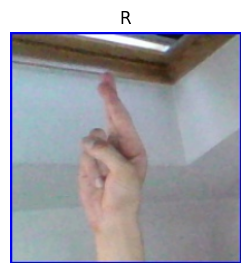

In [35]:
# Sanity check
print("Dataset len:")
print(len(train_dataset))

print("\nDataset classes:")
print(train_dataset.classes)

print("\nRandom images from dataset:")
img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()


In [36]:
# Train dataset and dataloader initialization
test_dataset = Dataset(root_dir="./dataset/asl_alphabet_test/", 
                        transform=transform,
                        dataset_type="test")

Dataset len:
29

Dataset classes:
['A', 'B', 'C', 'del', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'nothing', 'N', 'O', 'P', 'Q', 'R', 'space', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random image from dataset:


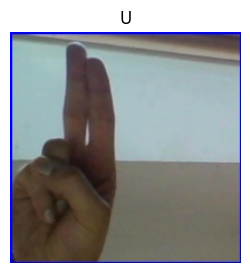

In [37]:
# Sanity check
print("Dataset len:")
print(len(test_dataset))

print("\nDataset classes:")
print(test_dataset.classes)

print("\nRandom image from dataset:")
img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()

## SPLITING DATA INTO TRAINING AND VALIDATION DATASETS

In [38]:
train_len = round(0.7 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_len, val_len, train_len + val_len == len(train_dataset)

(60900, 26100, True)

In [39]:
train_dataset_, val_dataset = random_split(train_dataset, [train_len, val_len])

In [40]:
# Sanity check once more

print(f"Number of training samples: {len(train_dataset_)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}") 
print(f"Number of classes: {len(train_dataset_.dataset.classes)}")

Number of training samples: 60900
Number of validation samples: 26100
Number of test samples: 29
Number of classes: 29


## DATALOADERS

In [41]:
train_dataloader = DataLoader(train_dataset_, 
                              batch_size=32, 
                              shuffle=True, 
                              num_workers=0)

val_dataloader = DataLoader(val_dataset,
                            batch_size=32,
                            shuffle=False,
                            num_workers=0)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=32, 
                             shuffle=False, 
                             num_workers=0)


In [42]:
# Sanity check
def loader_sanity_check(loader):
    for batch_idx, (data, labels) in enumerate(loader):
        print(f"Batch nr: {batch_idx}")
        print(f"Batch size: {data.shape[0]}")
        print(f"Data shape: {data.shape}")
        print(f"Image shape: {data[0].shape}")
        print(f"Classes: {labels}")
        print(f"Num classes: {len(labels)}")
        break

In [43]:
loader_sanity_check(train_dataloader)

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: ('R', 'F', 'C', 'space', 'K', 'space', 'Q', 'H', 'C', 'Y', 'D', 'H', 'E', 'X', 'F', 'V', 'B', 'X', 'E', 'nothing', 'O', 'J', 'U', 'K', 'B', 'H', 'del', 'B', 'U', 'D', 'A', 'D')
Num classes: 32


In [44]:
loader_sanity_check(val_dataloader)

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: ('M', 'V', 'M', 'space', 'R', 'L', 'space', 'B', 'N', 'P', 'L', 'I', 'P', 'M', 'A', 'U', 'P', 'T', 'Y', 'M', 'J', 'S', 'I', 'O', 'A', 'space', 'Z', 'G', 'D', 'X', 'del', 'Q')
Num classes: 32


In [45]:
loader_sanity_check(test_dataloader)

Batch nr: 0
Batch size: 29
Data shape: torch.Size([29, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: ('A', 'B', 'C', 'del', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'nothing', 'N', 'O', 'P', 'Q', 'R', 'space', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z')
Num classes: 29


## MODEL